In [1]:
import sys
sys.path.append('../')
import importlib
import model.op
importlib.reload(model.op)
from model.op import number_aircrafts_lp

## Default parameters in LP

- Timestep: 5 min

- Flight time tau: 2 timesteps

- Kappa: 10% charge, 4 levels of SOC

- Gamma: 32 SOCs


# Run LP

In [5]:
number_aircrafts_lp(schedule='schedule_10min_0610', schedule_time_step=288, output_path='schedule_10min_0610')

Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-10910 CPU @ 3.60GHz
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 21490 rows, 345708 columns and 703346 nonzeros
Model fingerprint: 0xb361df81
Variable types: 0 continuous, 345708 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 1931 rows and 7248 columns
Presolve time: 0.91s
Presolved: 19559 rows, 338460 columns, 689774 nonzeros
Variable types: 0 continuous, 338460 integer (0 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.59s

Barrier statistics:
 AA' NZ     : 3.646e+05
 Factor NZ  : 6.189e+06 (roughly 200 M

# LP Output Visualization

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import model.ParseLP
importlib.reload(model.ParseLP)
from model.ParseLP import convert2df, calculate_num_aircrafts

In [40]:
output_file = 'output_12_miles_5min_middle_charging'
specificn, specificu, specificc = convert2df(output_file)
print(specificu.sum())

t                                                    214574
i                                                      1143
j                                                      1128
k                                                     21336
amount                                               1546.0
name      uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu...
dtype: object


In [41]:
specificu[(specificu['i'] == 0) & (specificu['j'] == 1)]['amount'].sum() * 15.58 + specificu[(specificu['i'] == 1) & ((specificu['j'] == 0))]['amount'].sum() * 14.46 + (specificu[specificu['i'] == 2]['amount'].sum() + specificu[specificu['j'] == 2]['amount'].sum()) * 9.045

18802.78

In [42]:
specificu[(specificu['i'] == 0) & (specificu['j'] == 1)]['amount'].sum() + specificu[(specificu['i'] == 1) & ((specificu['j'] == 0))]['amount'].sum()

806.0

In [43]:
specificu[specificu['i'] == 2]['amount'].sum() + specificu[specificu['j'] == 2]['amount'].sum()

740.0

In [16]:
# Obtain Airport Specific Aircraft States
specificu01 = specificu[specificu['i'] == 0].reset_index(drop=True)
specificu10 = specificu[specificu['i'] == 1].reset_index(drop=True)

specificc01 = specificc[specificc['i'] == 0].reset_index(drop=True)
specificc10 = specificc[specificc['i'] == 1].reset_index(drop=True)

specificn01 = specificn[specificn['i'] == 0].reset_index(drop=True)
specificn10 = specificn[specificn['i'] == 1].reset_index(drop=True)

In [17]:
lax_all_c, lax_all_n, lax_all_u = calculate_num_aircrafts(specificc01, specificu01, specificn01)
dtla_all_c, dtla_all_n, dtla_all_u = calculate_num_aircrafts(specificc10, specificu10, specificn10)
all_c, all_n, all_u = calculate_num_aircrafts(specificc, specificu, specificn)

# State Visulization

In [11]:
(lax_all_c.sum(axis=0)[x0:x1] + lax_all_n.sum(axis=0)[x0:x1]).max()

7.0

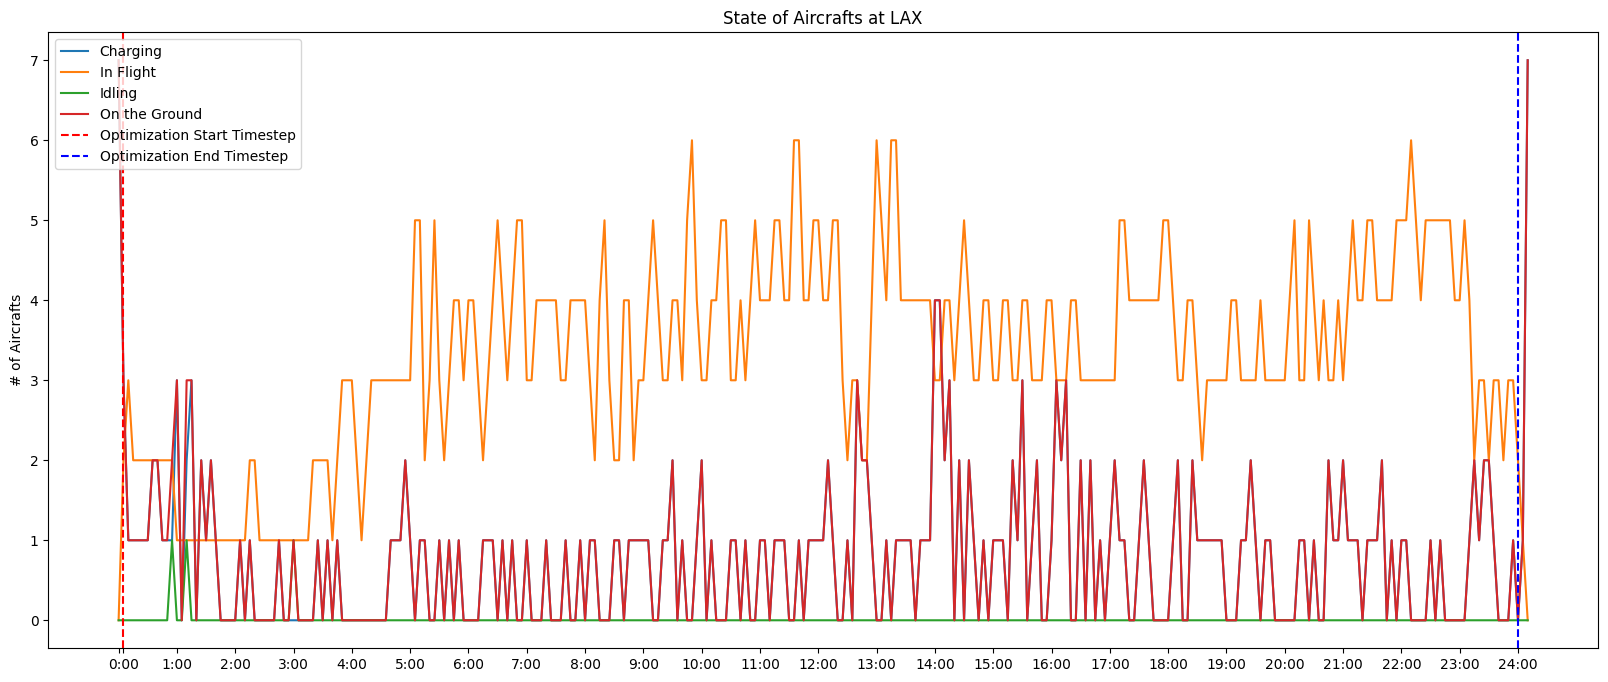

In [6]:
x0 = 0
x1 = 291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(lax_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(lax_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(lax_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((lax_all_c.sum(axis=0)[x0:x1] + lax_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts at LAX',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');

In [7]:
print('At t = 0, c =', lax_all_c.sum(axis=0)[x0:x1][0], '; u=', lax_all_u.sum(axis=0)[x0:x1][0], '; n=', lax_all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', lax_all_c.sum(axis=0)[x0:x1][286], '; u=', lax_all_u.sum(axis=0)[x0:x1][286], '; n=', lax_all_n.sum(axis=0)[x0:x1][286])

At t = 0, c = 7.0 ; u= 0.0 ; n= 0.0
At t = 290, c = 0.0 ; u= 3.0 ; n= 0.0


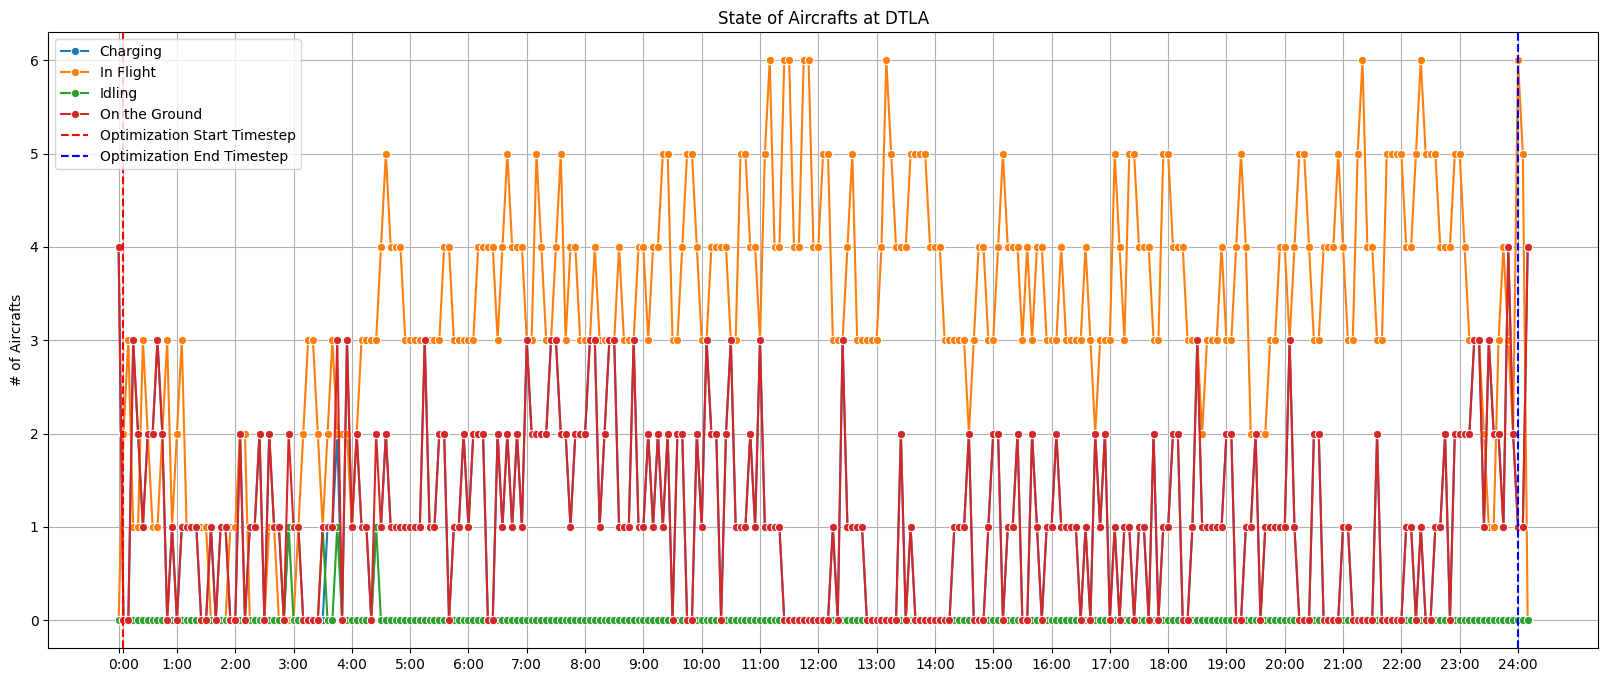

In [18]:
x0 = 0
x1 = 291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(dtla_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax, marker='o')
sns.lineplot(dtla_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax, marker='o')
sns.lineplot(dtla_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax, marker='o')
sns.lineplot((dtla_all_c.sum(axis=0)[x0:x1] + dtla_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax, marker='o')
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts at DTLA',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');
plt.grid()

In [19]:
(dtla_all_c.sum(axis=0)[x0:x1] + dtla_all_n.sum(axis=0)[x0:x1]).max()

4.0

In [9]:
print('At t = 0, c =', dtla_all_c.sum(axis=0)[x0:x1][0], '; u=', dtla_all_u.sum(axis=0)[x0:x1][0], '; n=', dtla_all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', dtla_all_c.sum(axis=0)[x0:x1][290], '; u=', dtla_all_u.sum(axis=0)[x0:x1][290], '; n=', dtla_all_n.sum(axis=0)[x0:x1][290])

At t = 0, c = 4.0 ; u= 0.0 ; n= 0.0
At t = 290, c = 4.0 ; u= 0.0 ; n= 0.0


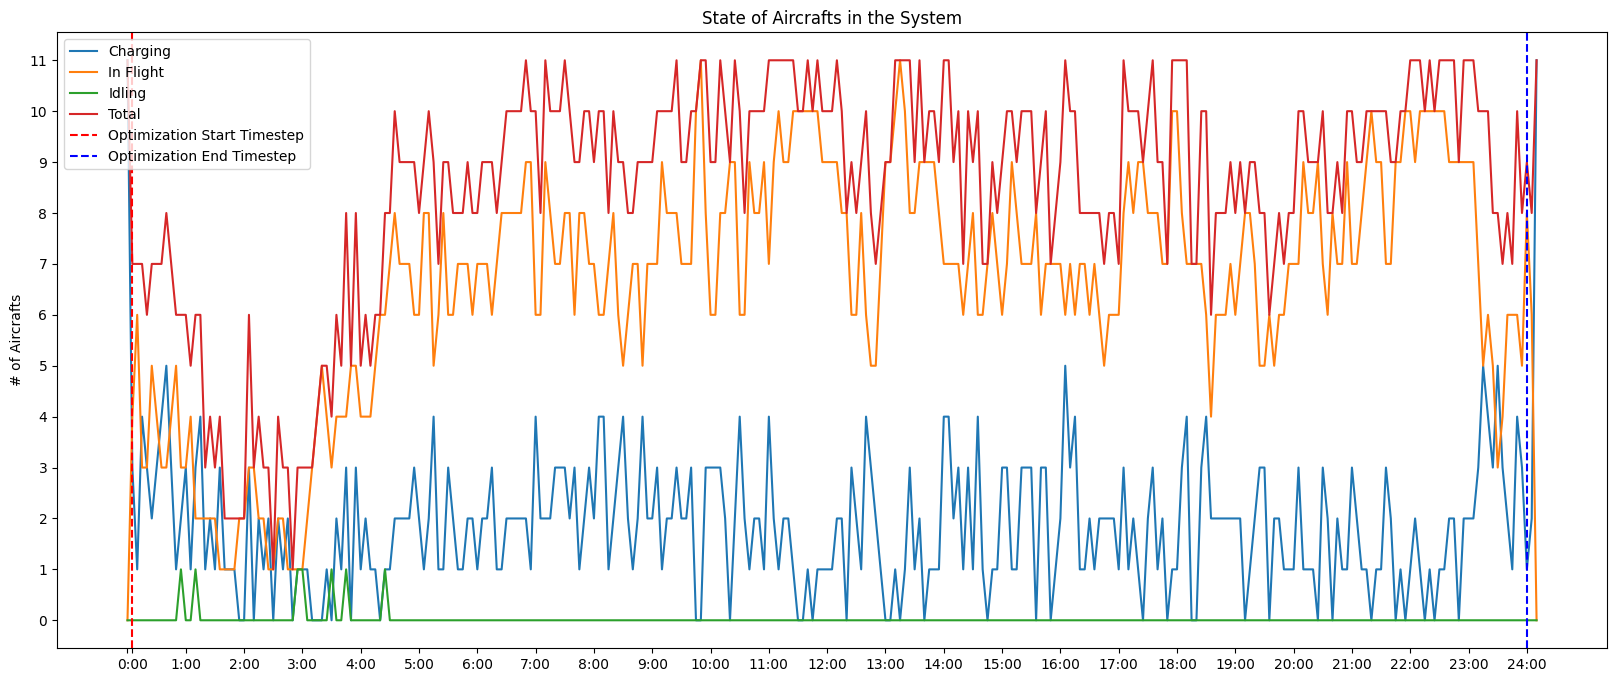

In [10]:
x0=0
x1=291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1] + all_n.sum(axis=0)[x0:x1]), label='Total', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts in the System',
       ylabel='# of Aircrafts',
       yticks=np.arange(0, (all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1] + all_n.sum(axis=0)[x0:x1])[0]+1),
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');
# plt.xlim([0, 10])

In [26]:
print('At t = 0, c =', all_c.sum(axis=0)[x0:x1][0], '; u=', all_u.sum(axis=0)[x0:x1][0], '; n=', all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', all_c.sum(axis=0)[x0:x1][290], '; u=', all_u.sum(axis=0)[x0:x1][290], '; n=', all_n.sum(axis=0)[x0:x1][290])

At t = 0, c = 4.0 ; u= 0.0 ; n= 7.0
At t = 290, c = 4.0 ; u= 0.0 ; n= 7.0
